In [1]:
# Importing necessary libraries
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy.sparse
from os import path

In [2]:
# Loading images
source = cv2.imread("/Users/dianatat/Documents/Master/C2 Optimisation techniques for CV/Project/week2/pictures/SOURCE.jpeg")
source = cv2.cvtColor(source, cv2.COLOR_BGR2RGB)

mask = cv2.imread("/Users/dianatat/Documents/Master/C2 Optimisation techniques for CV/Project/week2/pictures/MASK.png")
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

target = cv2.imread("/Users/dianatat/Documents/Master/C2 Optimisation techniques for CV/Project/week2/pictures/TARGET.jpg")
target = cv2.cvtColor(target, cv2.COLOR_BGR2RGB)

In [3]:
# Print shapes for verification
print(f"target shape: {target.shape}")
print(f"source shape: {source.shape}")
print(f"mask shape: {mask.shape}")

target shape: (4032, 3024, 3)
source shape: (720, 1280, 3)
mask shape: (720, 1280)


In [4]:
# Defining Laplacian matrix function
def laplacian_matrix(n, m):   
    mat_D = scipy.sparse.lil_matrix((m, m))
    mat_D.setdiag(-1, -1)
    mat_D.setdiag(4)
    mat_D.setdiag(-1, 1)

    mat_A = scipy.sparse.block_diag([mat_D] * n).tolil()

    mat_A.setdiag(-1, 1*m)
    mat_A.setdiag(-1, -1*m)

    return mat_A

In [5]:
# Setting up the offset
offset = (1450, 100)

# Define the region of the target where the source will be blended using the offset
y_start, y_end = offset[1], offset[1] + mask.shape[0]
x_start, x_end = offset[0], offset[0] + mask.shape[1]

# Adjusting the mask dimensions to match target's region
target_mask = np.zeros_like(target[:,:,0])
target_mask[y_start:y_end, x_start:x_end] = mask

# Ensure that the mask fits into the target image
assert target_mask.shape == target[:,:,0].shape, "The mask after applying offset doesn't fit the target image."

# Adjusting the source region to be blended
source_region = source[0:mask.shape[0], 0:mask.shape[1]]

# Adjusting the Laplacian matrix based on the target region
mat_A = laplacian_matrix(y_end - y_start, x_end - x_start)

In [6]:
# Adjusting the matrix A according to mask boundaries
for y in range(1, y_end - y_start - 1):
    for x in range(1, x_end - x_start - 1):
        if target_mask[y+y_start, x+x_start] == 0:
            k = x + y * (x_end - x_start)
            mat_A[k, k] = 1
            mat_A[k, k + 1] = 0
            mat_A[k, k - 1] = 0
            mat_A[k, k + (x_end - x_start)] = 0
            mat_A[k, k - (x_end - x_start)] = 0

mat_A = mat_A.tocsc()

In [10]:
# Blending each channel of the source into the target
mask_flat = target_mask[y_start:y_end, x_start:x_end].flatten()
for channel in range(source_region.shape[2]):
    source_flat = source_region[:, :, channel].flatten()
    target_flat = target[y_start:y_end, x_start:x_end, channel].flatten()

    # Using the Laplacian blend method
    alpha = 1
    mat_b = mat_A.dot(source_flat) * alpha

    mat_b[mask_flat == 0] = target_flat[mask_flat == 0]

    x = spsolve(mat_A, mat_b)
    x = x.reshape((y_end - y_start, x_end - x_start))
    x[x > 255] = 255
    x[x < 0] = 0
    x = x.astype('uint8')

    target[y_start:y_end, x_start:x_end, channel] = x


result = cv2.cvtColor(target, cv2.COLOR_BGR2RGB)

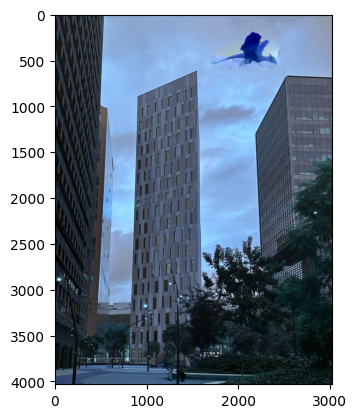

In [9]:
plt.figure()
plt.imshow(result, cmap='gray')
plt.show()